Two Sigma Data Challenge

In [200]:
import requests
import io
from datetime import date,timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [133]:
warnings.filterwarnings('ignore')
URL = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
grpby_list1 = ['C/A','UNIT','SCP']
grpby_list2 = ['C/A','UNIT','SCP','DATE']
grpby_list3 = ['C/A','DATE']
grpby_list4 = ['C/A','UNIT','DATE']
ca_station_map = pd.Series.from_csv('ca_station.csv')
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [2]:
def get_all_saturdays(year):
    d = date(year,1,1)
    d += timedelta(days = (5 - d.weekday()) % 7)
    datelist = []
    while(d.year == year):
        datelist.append(d.strftime("%y%m%d")+".txt")
        d += timedelta(days=7)
    return datelist

def get_header_list():
    header = 'C/A,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,DESC2,ENTRIES2,EXITS2,DATE3,TIME3,DESC3,ENTRIES3,EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4,DATE5,TIME5,DESC5,ENTRIES5,EXITS5,DATE6,TIME6,DESC6,ENTRIES6,EXITS6,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8'
    return header.split(',')

def get_bool_lists():
    bool_list = []
    base = [True for x in range(0,3)]
    for i in range(8):
        pre =  [False for x in range(3,3+(i*5))]
        true = [True for x in range(3+(i*5),8+(i*5))]
        post = [False for x in range(8+(i*5),43)]
        bool_list.append(base + pre + true + post)
    return bool_list

def old_format_to_new(df):
    dflist = []
    bool_list = get_bool_lists()
    for a in bool_list:
        temp = df.loc[:,a]
        temp.columns = 'C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS'.split(',')
        dflist.append(temp)
    return pd.concat(dflist)

In [15]:
# num = 1, for df of Aug 1 file
# num = 2, for Q3
# num = 3, year-long
# num = 4, recent file
# Using URL downloads to ensure system-independance

def csv_downloader(num):
    global URL, grpby_list2, grpby_list3, grpby_list4
    datelist3 = get_all_saturdays(2013)
    datelist1 = ['130803.txt']
    datelist2 = datelist3[26:40]
    date4 = '180414.txt'
    with requests.Session() as s:
        if(num == 1):
            download = [s.get(URL + a) for a in datelist1]
        elif(num == 2):
            download = [s.get(URL + a) for a in datelist2]
            ca_list = []
            lines = []
            for a in datelist2:
                download = s.get(URL + a)
                temp_df = pd.read_csv(io.StringIO(download.content.decode('utf-8')),
                                      header = None, 
                                      names = get_header_list())
                lines.append(len(temp_df))
                temp_df = old_format_to_new(temp_df)
                gb2 = temp_df.groupby(grpby_list2)
                temp_df2 = gb2.agg({'ENTRIES' : np.ptp, 'EXITS' : np.ptp})
                temp_df2 = temp_df2.reset_index()
                gb3 = temp_df2.groupby(grpby_list4)
                temp_df3 = gb3.agg({'ENTRIES' : np.sum, 'EXITS' : np.sum})
                ca_list.append(temp_df3.reset_index())
                del temp_df,temp_df2,temp_df3
            return (lines,pd.concat(ca_list))
        elif(num ==3):
            #The follwing could have been done in better/faster ways
            #But doing like this to increase readability
            ca_list = []
            for a in datelist3:
                download = s.get(URL + a)
                temp_df = pd.read_csv(io.StringIO(download.content.decode('utf-8')),
                                      header = None, 
                                      names = get_header_list())
                temp_df = old_format_to_new(temp_df)
                gb2 = temp_df.groupby(grpby_list2)
                temp_df2 = gb2.agg({'ENTRIES' : np.ptp, 'EXITS' : np.ptp})
                temp_df2 = temp_df2.reset_index()
                gb3 = temp_df2.groupby(grpby_list3)
                temp_df3 = gb3.agg({'ENTRIES' : np.sum, 'EXITS' : np.sum})
                ca_list.append(temp_df3.reset_index())
                del temp_df,temp_df2,temp_df3
            return pd.concat(ca_list)
        else:
            download = s.get(URL + date4)
            return  pd.read_csv(io.StringIO(download.content.decode('utf-8')))
     
    df = pd.concat([pd.read_csv(io.StringIO(x.content.decode('utf-8')),header = None, names = get_header_list())for x in download])
    return df

In [128]:
#DA q1 Which station has the most number of units as of today?
dfq1 = csv_downloader(4)
dfq1.groupby('STATION').UNIT.nunique().idxmax() 

'23 ST'

In [129]:
#DA q2 What is the total number of entries & exits across the subway system for August 1, 2013?
dfq1 = csv_downloader(1)
df1 = old_format_to_new(dfq1)
df1 = df1[df1['DATE'] == '08-01-13']

gb = df1.groupby(grpby_list1)
df2 = gb.agg({'ENTRIES' : np.ptp, 'EXITS' : np.ptp})
df2.sum()

EXITS      9798396
ENTRIES   10245293
dtype: float64

In [130]:
#DA q3 Let’s define the busy-ness as sum of entry & exit count. 
# What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?

df2['total']= df2['ENTRIES'] + df2['EXITS']
df2 = df2.reset_index()
df2['station'] = df2['C/A'].apply(lambda x: ca_station_map[x] 
     if x in ca_station_map.index else 'UNDEF' + x)
gb2 = df2.groupby('station')
df2qa = gb2.agg({'total' : np.sum})
print df2qa['total'].idxmax()

print df2['SCP'].iat[df2['total'].idxmax()]

42 ST-BRYANT PK
02-00-04


In [8]:
#DA q4 What stations have seen the most usage growth/decline in 2013?
# The station data is not according for 2013 MTA files.
# C/A can uniquely identify a station
# But the complete mapping C/A to STATION is not available for 2013.
# Using the value UNDEF+C/A as station name when the info is not present  

dfq4 = csv_downloader(3)
dfq4['total'] = dfq4['ENTRIES'] + dfq4['EXITS']
dfq4['station'] = dfq4['C/A'].apply(lambda x: ca_station_map[x] \
     if  x in ca_station_map.index else 'UNDEF' + x)

gb3 = dfq4.groupby('station')    
dfq4a = gb3.agg({'total' : np.ptp})    
dfq4a = dfq4a.sort_values(by=['total'],ascending=False)
dfq4a.head()

                     total
station                   
183 ST          1626484716
GRAND ST        1617271968
MORGAN AVE      1301362492
42 ST-BRYANT PK 1232481246
DYRE AVE        1067115072


In [131]:
# DA q5  What dates in 2013 are the least busy? 
# Could you identify days in 2013 on which stations were not operating at full capacity or closed entirely?
# List of dates which were least busy
gb4 = dfq4.groupby('DATE')
dfq5a = gb4.agg({'total' : np.sum})
dfq5a.sort_values(by=['total'], inplace=True)
dfq5a.head()

,total
DATE,
02-09-13,3820380
03-31-13,4001697
02-24-13,4033872
01-13-13,4064633
07-07-13,4109920


In [132]:
#List of C/As which were closed completely by dates 
gb3 = dfq4.groupby(['station','DATE'])
dfq5b = gb3.agg({'total' : np.sum})
dfq5b = dfq5b[(dfq5b.total ==0)]
dfq5b

total
station         DATE           
104 ST          06-02-13      0
149 ST-3 AVE    01-03-13      0
14TH STREET     01-06-13      0
161 ST-YANKEE   07-18-13      0
                07-19-13      0
182-183 ST      01-24-13      0
183 ST          10-13-13      0
190 ST          04-07-13      0
                04-14-13      0
191 ST          08-18-13      0
                10-27-13      0
225 ST          07-25-13      0
                07-26-13      0
238 ST          09-07-13      0
                09-08-13      0
242 ST          09-08-13      0
                10-06-13      0
                10-27-13      0
45 ST           10-29-13      0
5 AVE-53 ST     02-08-13      0
                02-21-13      0
                07-11-13      0
9TH STREET      01-06-13      0
AQUEDUCT TRACK  03-16-13      0
                03-19-13      0
                03-20-13      0
                03-22-13      0
                03-27-13      0
                03-31-13      0
                04-03-13      0
...                         ...
UNDEFA049       12-30-12      0
                12-31-12      0
UNDEFR101       01-10-13      0
                01-12-13      0
                01-13-13      0
                01-15-13      0
                01-16-13      0
                01-20-13      0
                01-21-13      0
                02-03-13      0
                03-20-13      0
UNDEFR612       05-03-13      0
VAN ALSTON-21ST 07-13-13      0
                07-14-13      0
                07-20-13      0
                08-03-13      0
                08-04-13      0
                08-10-13      0
                08-17-13      0
                09-07-13      0
                09-08-13      0
                09-28-13      0
                09-29-13      0
                10-05-13      0
                10-06-13      0
                12-14-13      0
                12-15-13      0
WILSON AVE      09-01-13      0
WOODLAWN ROAD   04-12-13      0
                07-09-13      0

[353 rows x 1 columns]

In [16]:
#Vizulization
dfvq1 = csv_downloader(2)

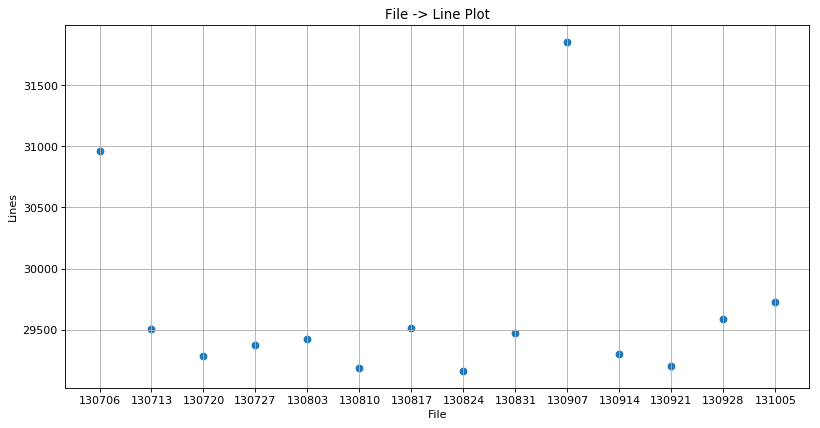

In [24]:
#Viz q1 Plot the daily row counts for data files in Q3 2013.
datelist = get_all_saturdays(2013)
xval = datelist[26:40]
xval = [x.rstrip('.txt') for x in xval]
plt.figure(figsize = (12,6),dpi=80)
plt.xlabel("File")
plt.ylabel("Lines")
plt.title("File -> Line Plot")    
plt.scatter(xval,dfvq1[0])
plt.grid(True)
plt.show()

In [40]:
#Viz q2 Plot the daily total number of entries & exits across the system for Q3 2013.
dfv = dfvq1[1]
extra_date_list = ['06-29-13','06-30-13','10-01-13','10-02-13','10-03-13','10-04-13']
dfv = dfv[~dfv['DATE'].isin(extra_date_list)]
gbv1 = dfv.groupby('DATE')
dfvq2 = gbv1.agg({'ENTRIES' : np.sum,'EXITS': np.sum})
dfvq2.index = dfvq2.index.to_datetime()

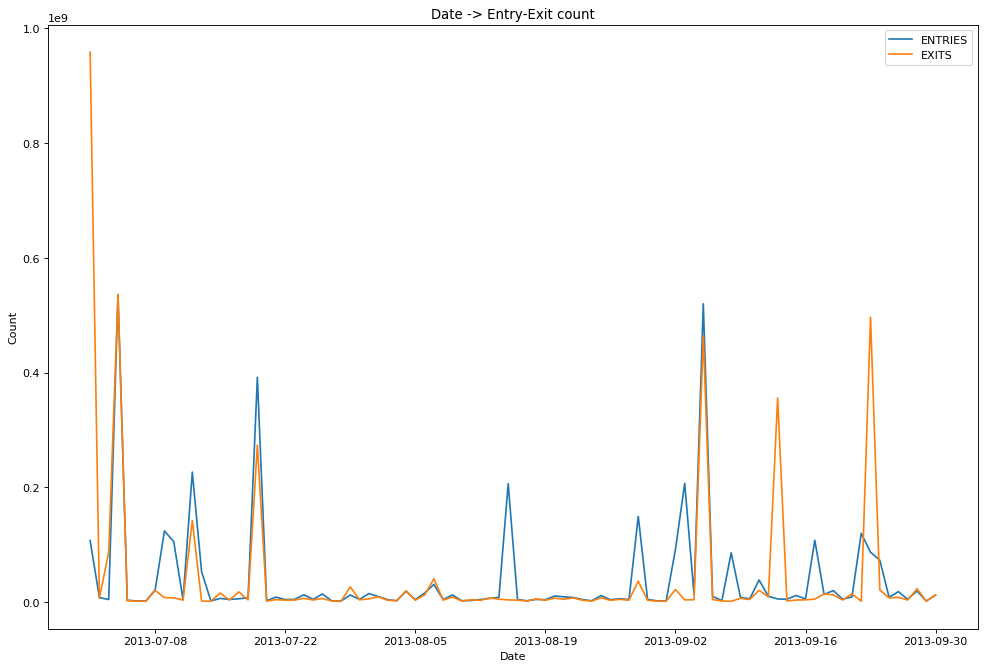

In [196]:
plt.figure(figsize = (15,10),dpi=80)
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Date -> Entry-Exit count") 
plt.plot(dfvq2.index,dfvq2.ENTRIES, label ='ENTRIES')
plt.plot(dfvq2.index,dfvq2.EXITS, label ='EXITS')
plt.legend()
plt.show()

In [51]:
# Viz Q3 - Plot the mean and standard deviation of the daily total number of 
# entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.
# Plot 25/50/75 percentile of the daily total number of entries & exits 
# for each month in Q3 2013 for station 34 ST-PENN STA.

dfv['station'] = dfv['C/A'].apply(lambda x: ca_station_map[x] if  x in ca_station_map.index else 'UNDEF' + x)
dfvpen = dfv[dfv['station'] == '34 ST-PENN STA']
dfvpen['DATE'] = pd.to_datetime(dfvpen.DATE,format='%m-%d-%y')
per = dfvpen.DATE.dt.to_period("M")
gbx = dfvpen.groupby(per)

dfvpenmean = gbx.mean()
dfvpenstd = gbx.std()
dfvpen25q = gbx.quantile(q=0.25)
dfvpen50q = gbx.quantile(q=0.5)
dfvpen75q = gbx.quantile(q=0.75)

dfvpenmean.reset_index(inplace=True)
dfvpenstd.reset_index(inplace=True)
dfvpen25q.reset_index(inplace=True)
dfvpen50q.reset_index(inplace=True)
dfvpen75q.reset_index(inplace=True)

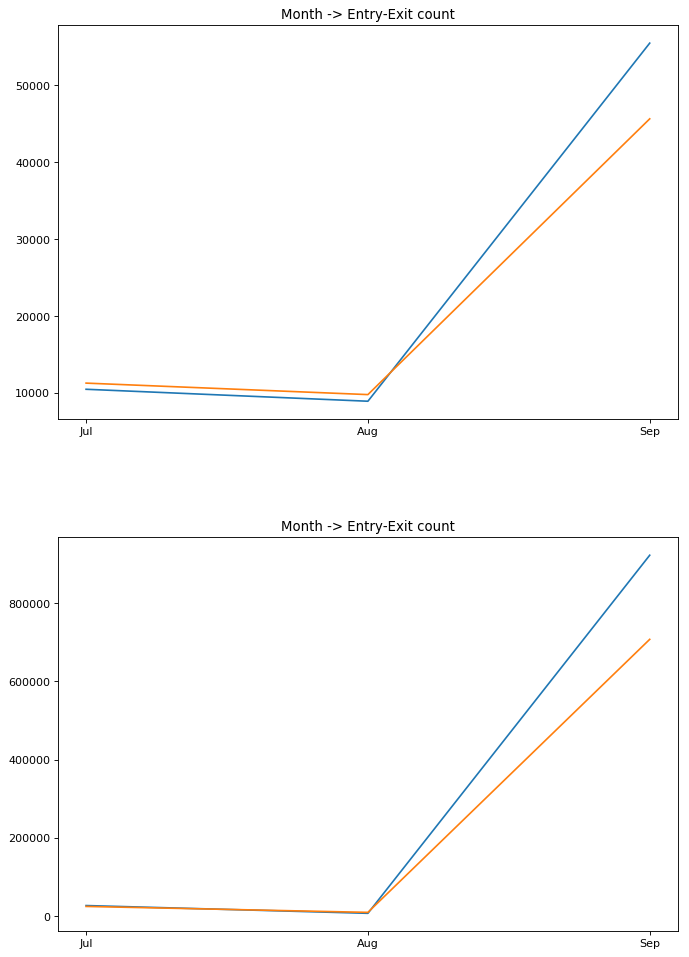

In [199]:
plt.figure(figsize = (10,15),dpi=80)
plt.subplot(211)
plt.title("Month -> Entry-Exit count")
plt.plot(dfvpenmean.EXITS)
plt.plot(dfvpenmean.ENTRIES)
plt.subplots_adjust(hspace =0.3)
plt.xticks(np.arange(3),('Jul','Aug','Sep'))
plt.subplot(212)
plt.title("Month -> Entry-Exit count")
plt.plot(dfvpenstd.EXITS)
plt.plot(dfvpenstd.ENTRIES)
plt.subplots_adjust(hspace = 0.3)
plt.xticks(np.arange(3),('Jul','Aug','Sep'))
plt.show()

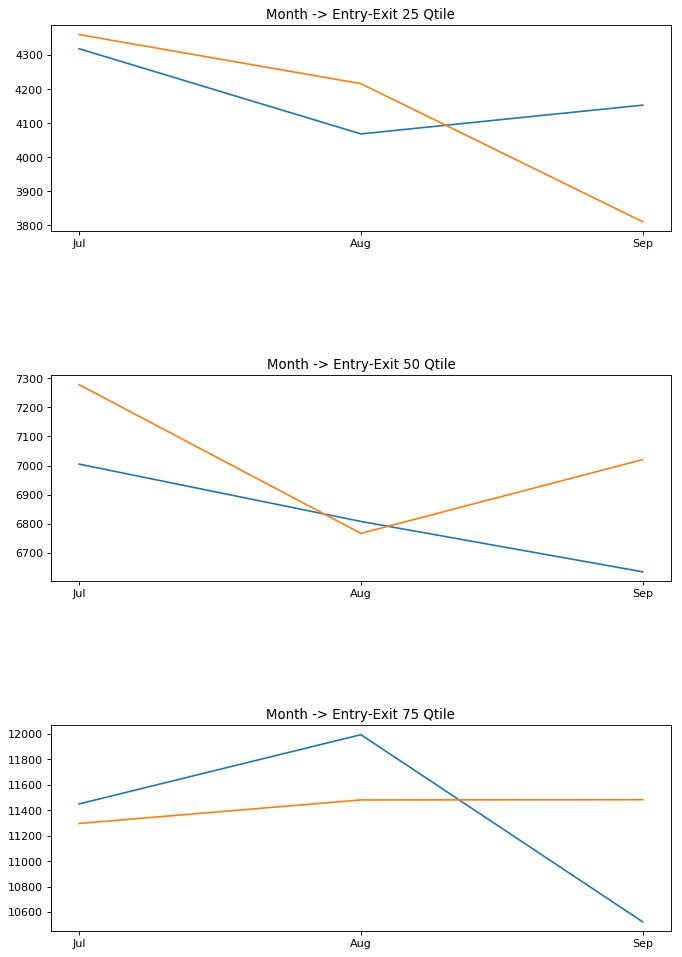

In [134]:
plt.figure(figsize = (10,15),dpi=80)
plt.subplot(311)
plt.title("Month -> Entry-Exit 25 Qtile")
plt.plot(dfvpen25q.EXITS)
plt.plot(dfvpen25q.ENTRIES)
plt.subplots_adjust(hspace =0.7)
plt.xticks(np.arange(3),('Jul','Aug','Sep'))
plt.subplot(312)
plt.title("Month -> Entry-Exit 50 Qtile")
plt.plot(dfvpen50q.EXITS)
plt.plot(dfvpen50q.ENTRIES)
plt.subplots_adjust(hspace = 0.7)
plt.xticks(np.arange(3),('Jul','Aug','Sep'))
plt.subplot(313)
plt.title("Month -> Entry-Exit 75 Qtile")
plt.plot(dfvpen75q.EXITS)
plt.plot(dfvpen75q.ENTRIES)
plt.subplots_adjust(hspace = 0.7)
plt.xticks(np.arange(3),('Jul','Aug','Sep'))
plt.show()

In [99]:
# Viz Q5 Plot the daily number of closed stations 
# and number of stations that were not operating at full capacity in Q3 2013.

#Closed Stations
gbx = dfv.groupby(['station','DATE'])
dfvq5 = gbx.agg({'ENTRIES' : np.sum, 'EXITS' : np.sum})
dfvq5.reset_index(inplace=True)
dfvq5 = dfvq5[(dfvq5.ENTRIES == 0) & (dfvq5.EXITS ==0)]
dfvq5a = dfvq5.groupby('DATE')
gby = dfvq5.groupby('DATE')
dfvq5a = dfvq5.DATE.value_counts()
temp = pd.Series(0,index=dfv.DATE.unique())
dfvq5a = dfvq5a.add(temp).fillna(0)
dfvq5a.sort_index(inplace=True)
dfvq5a.index = dfvq5a.index.to_datetime()

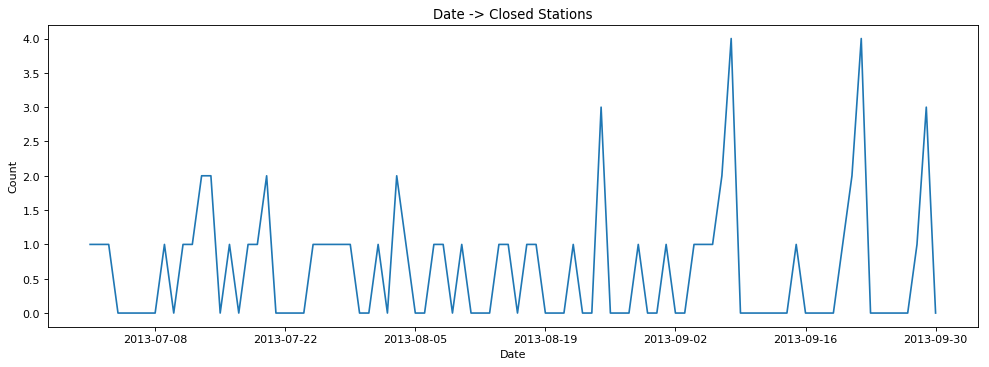

In [198]:
plt.figure(figsize = (15,5),dpi=80)
plt.title("Date -> Closed Stations") 
plt.xlabel("Date")
plt.ylabel("Count")
plt.plot(dfvq5a.index, dfvq5a.values)

In [194]:
#Not at Full Capacity
dfvq5b = dfv[(dfv.ENTRIES == 0) & (dfv.EXITS ==0)]
dfvq5b = dfvq5b.DATE.value_counts()
dfvq5b.sort_index(inplace=True)
dfvq5b.index = dfvq5b.index.to_datetime()

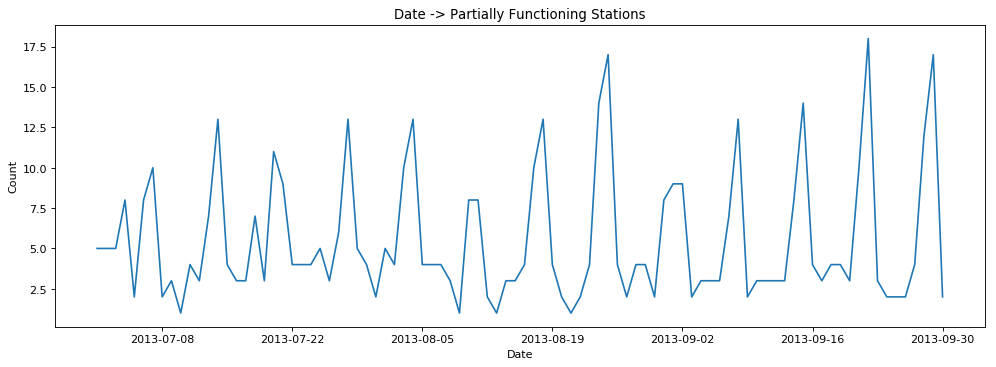

In [197]:
plt.figure(figsize = (15,5),dpi=80)
plt.title("Date -> Partially Functioning Stations") 
plt.xlabel("Date")
plt.ylabel("Count")
plt.plot(dfvq5b.index, dfvq5b.values) 